# `focustools` Python Tutorial

## Getting started

For this tutorial, let's download [EMD-4738](https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-4738) as an example on how to use the `focustools` Python module.

(**NOTE:** internally, EMDB stores 3D maps in the MAP format, which is almost identical to the MRC format except the internal coordinates are stored in a different order - nothing to worry about here)

In [ ]:
%%bash

# Download the EMDB-4738 map:
wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-4738/map/emd_4738.map.gz

# Unzip it:
gunzip emd_4738.map.gz

Now we can move into Python:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # For displaying stuff
import matplotlib.cm as cm # For colormaps
import mrcz # For I/O of MRCZ files - compressed or not!
import numpy as np # NumPy gives us the real number crunching on the go

And, most importantly:

In [2]:
from focustools import util

## Reading in a map with MRCZ

In [3]:
# Now let's load our map as a NumPy array
mrc,hed =  mrcz.ioMRC.readMRC('emd_4738.map')

In [4]:
# mrc is a list of NumPy arrays (in this case just one 3D array):
print(len(mrc))
print(mrc[0].shape)
# hed is a dictionary containing the header of the file we just read:
print(hed)

# For convenience, let's call mrc[0] "ourmap":
ourmap = mrc[0]

1
(384, 384, 384)
{'dimensions': array([384, 384, 384], dtype=int32), 'MRCtype': 2, 'compressor': None, 'dtype': '<f4', 'pixelsize': array([1.01500003, 1.01500003, 1.01500003]), 'pixelunits': '\\AA', 'minImage': -0.10898206, 'maxImage': 0.18135783, 'meanImage': 5.5498695e-05, 'extendedBytes': 0, 'voltage': 0.0, 'C3': 0.0, 'gain': 0.0, 'packedBytes': (0,)}


## Writing out maps using MRCZ

Let's write compressed and non-compressed versions of our map and compare their file sizes:

In [5]:
mrcz.writeMRC(ourmap,'ourmap.mrc',compressor=None,pixelsize=hed['pixelsize']) # Default compressor is None
mrcz.writeMRC(ourmap,'ourmap.mrcz',compressor='zstd',pixelsize=hed['pixelsize'])

In [6]:
!ls -sh ourmap.mrc
!ls -sh ourmap.mrcz

217M ourmap.mrc
116M ourmap.mrcz


## Doing something with the map as NumPy array

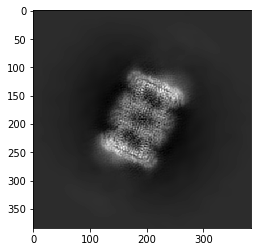

In [7]:
# Let's calculate and display "projections" of the map:
proj = ourmap.sum(axis=0) # Along Z, in real space
plt.imshow(proj,cmap=cm.gray)

## Filtering the map

Now we are going to use the `focustools` utilities for filtering the map.  
You can check the [release notes](https://github.com/C-CINA/focustools/blob/master/RELEASE_NOTES.md) for all functions currently implemented.

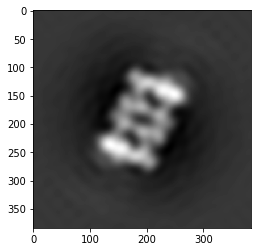

In [8]:
# Pixel size is 1.015 A/px. We take it from the header we read above.
# Let's low-pass filter the map to 20 A using a cosine edge 8 pixels-wide (actually these are voxels in Fourier space)
maplp = util.FilterCosine(ourmap, apix=hed['pixelsize'][0], lp=20.0, width=8)
plt.imshow(maplp.sum(axis=0), cmap=cm.gray) # Let's display a projection of the low-pass filtered map

### `focustools` also works in 2D

We can do just the same we did above, directly on our 2D projection:

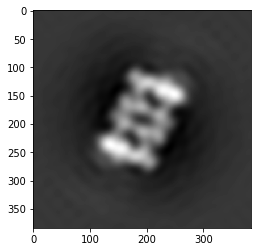

In [9]:
projlp = util.FilterCosine(proj, apix=hed['pixelsize'][0], lp=20.0, width=8)
plt.imshow(projlp, cmap=cm.gray) # Let's plot a display of the low-pass filtered map

Note that one can use the same functions above to high-pass or band-pass maps. 
There are also other possible shapes for the filters. `FilterCosine`, `FilterTophat` (which is a special case of cosine), `FilterGaussian` and `FilterBfactor` (which is a special case of Gaussian) are currently implemented:

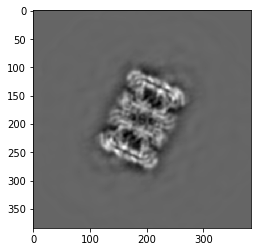

In [10]:
mapbp = util.FilterGauss(ourmap, apix=hed['pixelsize'][0], hp=30.0, lp=10.0)
plt.imshow(mapbp.sum(axis=0), cmap=cm.gray) # Let's display a projection of the Gaussian band-pass filtered map

## Computing the Guinier plot of the map

Now, let's use `focustools` to compute the [Guinier plot](http://gisaxs.com/index.php/Guinier_plot), which is $log(amplitudes)$ vs. $1/freq^2$:

In [11]:
NSAM = util.GetNumberOfFourierSamples(ourmap.shape) # Get the number of Fourier samples. Shape doesn't need to be square or cubic.
print('The number of Fourier samples is %d' % NSAM)

amps = util.RadialProfile(ourmap, amps=True)[:NSAM] # Tell it we want the amplitude profile, not the real-space profile.
# We take the above only up to NSAM, because the FT is redundant in this case.
logamps = np.log(amps) # log the amps

freq = util.GetFreqArray(NSAM, apix=hed['pixelsize'][0]) # Get the frequency array
freq2 = freq ** 2 # Square it

The number of Fourier samples is 193


Text(0.5, 0, 'Spatial frequency^2 (1/A^2)')

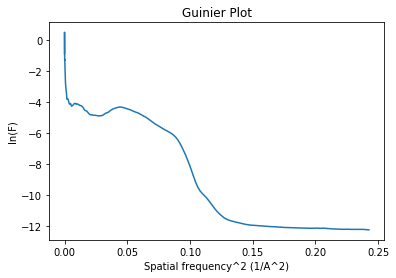

In [12]:
# Now plot it:
plt.plot(freq2, logamps)
plt.title('Guinier Plot')
plt.ylabel('ln(F)')
plt.xlabel('Spatial frequency^2 (1/A^2)')

## High-Resolution Noise Substitution

We can also randomize the phases of our map beyond a given resolution, for the method proposed by [Chen _et al._, Ultramicroscopy (2013)](https://doi.org/10.1016/j.ultramic.2013.06.004):

In [13]:
# Let's randomize all the phases beyond 1/(10 A):
ourmap_noisy = util.HighResolutionNoiseSubstitution(ourmap, apix=hed['pixelsize'][0], lp=10.0, random_seed=123)

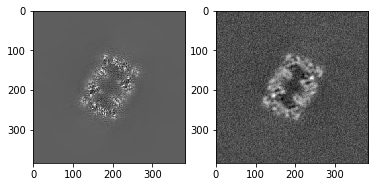

In [14]:
# Let's compare slices from the original map and the phase-randomized map:
fig, axs = plt.subplots(1,2)
axs[0].imshow(ourmap[ourmap.shape[0]//2,:,:], cmap=cm.gray)
axs[1].imshow(ourmap_noisy[ourmap.shape[0]//2,:,:], cmap=cm.gray)

## Computing the FSC

Let's compute and display the FSC between the original and the phase-randomized map:

In [15]:
fsc = util.FSC(ourmap, ourmap_noisy)
print(fsc.shape)

(334, 1)


Text(0.5, 0, 'Spatial frequency (1/$\\rm \\AA$)')

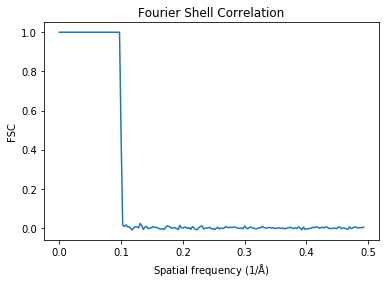

In [16]:
# Using the frequency array from above, we now plot the FSC:
plt.plot(freq, fsc[:NSAM])
plt.title('Fourier Shell Correlation')
plt.ylabel('FSC')
plt.xlabel(r'Spatial frequency (1/$\rm \AA$)')

As expected, the FSC drops sharply beyond the resolution of 10 A.